https://towardsdatascience.com/stock-prediction-using-recurrent-neural-networks-c03637437578

https://viblo.asia/p/recurrent-neural-networkphan-1-tong-quan-va-ung-dung-jvElaB4m5kw

https://nttuan8.com/bai-13-recurrent-neural-network/

https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html

https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru

In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()


# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

# #display parent directory and working directory
# print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
# print(os.getcwd()+':', os.listdir(os.getcwd()));

In [2]:
# import all stock prices 
df = pd.read_csv("../db/Tesla.csv", index_col = 0)
df.info()
df.head()

# # number of different stocks
# print('\nnumber of different stocks: ', len(list(set(df.symbol))))
# print(list(set(df.symbol))[:10])

<class 'pandas.core.frame.DataFrame'>
Index: 1692 entries, 6/29/2010 to 3/17/2017
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1692 non-null   float64
 1   High       1692 non-null   float64
 2   Low        1692 non-null   float64
 3   Close      1692 non-null   float64
 4   Volume     1692 non-null   int64  
 5   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 92.5+ KB


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [3]:
df.tail()


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
3/13/2017,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
3/14/2017,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
3/15/2017,257.000000,261.000000,254.270004,255.729996,4816600,255.729996
3/16/2017,262.399994,265.750000,259.059998,262.049988,7100400,262.049988
3/17/2017,264.000000,265.329987,261.200012,261.500000,6475900,261.500000


In [4]:
df.describe()
df.columns=["open", "high","low", "close", "adjclose", "volume"]


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1692 entries, 6/29/2010 to 3/17/2017
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      1692 non-null   float64
 1   high      1692 non-null   float64
 2   low       1692 non-null   float64
 3   close     1692 non-null   float64
 4   adjclose  1692 non-null   int64  
 5   volume    1692 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 92.5+ KB


In [6]:
# choose a specific stock
# drop feature: volume
# normalize stock data
# create train, validation and test data sets

# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data)
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:4]
    y_train = data[:train_set_size,-1,:4]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:4]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:4]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:4]
    y_test = data[train_set_size+valid_set_size:,-1,:4]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df.copy()
# df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)



df_stock.columns.values =  ['open', 'high', 'low', 'close', 'adjclose']
x_train.shape =  (1338, 19, 4)
y_train.shape =  (1338, 4)
x_valid.shape =  (167, 19, 4)
y_valid.shape =  (167, 4)
x_test.shape =  (167, 19, 4)
y_test.shape =  (167, 4)
<ipython-input-6-6825cdae3e25>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_stock.drop(['volume'],1,inplace=True)


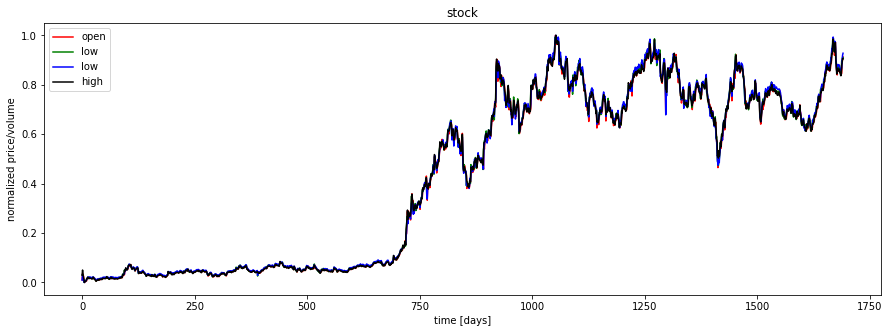

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [8]:
# 4. Model and validate data 
# RNNs with basic

## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.compat.v1.reset_default_graph()
# tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        
        # sess.run(training_op, feed_dict={X: x_batch.reshape(((50 , 19, 4))), y: y_batch.reshape(((, 4)))}) 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 

        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/Library/Python/3.8/site-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:427: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be "
/Library/Python/3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/Library/Python/3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is dep

KeyboardInterrupt: 